# 实验报告

#### 作者   顾淳 李优泉

## 0.数据集介绍

    - CIFAR-10是8000万个微型图像数据集的被标注过后的子集。它们由Alex Krizhevsky，Vinod Nair和Geoffrey Hinton收集。
    - CIFAR-10数据集包含10个类别的60000个32x32彩色图像，每个类别有6000张图像。有50000张训练图像和10000张测试图像。
    - 数据集分为五个训练批次和一个测试批次，每个批次具有10000张图像。测试集包含从每个类别中1000张随机选择的图像。剩余的图像按照随机顺序构成5个批次的训练集，每个批次中各类图像的数量不相同，但总训练集中每一类都正好有5000张图片。
    - 数据集中一个有10个类别，分别为：'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。

## 1.准备工作

### 载入库

In [1]:
import torch
import numpy as np
from torch import nn

### 检验CUDA是否可用

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available...");

CUDA is available!


### 一些参数

In [3]:
#验证集大小(占训练集比例)
valid_size = 0.2

#加载数据集的子进程个数
num_workers = 2

#data loader每批数据个数
batch_size = 16

### 对原始数据进行预处理
    将数据从 [0, 255] 转换成 [-1, 1]

In [4]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(), #将数据有[0,255]转换为[0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #将三个维度的数据由[0,1]转换为[-1,1]
    ])

### 加载数据集
在官网上下载CIFAR-10数据集，解压至本目录下。

In [5]:
from torchvision.datasets import CIFAR10
train_set = CIFAR10('./', train=True, transform=transform)
test_set = CIFAR10('./', train=False, transform=transform)
#观察数据集的class
print('原始数据集class：', type(train_set), '\n')

#打印出原始数据集训练集和测试集大小
train_num = len(train_set)
test_num = len(test_set)
print('CIFAR10 Train set size:', train_num)
print('CIFAR10 Test set size:', test_num)

原始数据集class： <class 'torchvision.datasets.cifar.CIFAR10'> 

CIFAR10 Train set size: 50000
CIFAR10 Test set size: 10000


### 划分 data loader
    将原始训练集分割为训练集和验证集，训练集占80%（40000），验证集占20%（10000），测试集（10000）。

    设置data loader,方便训练时取出数据。每一批取出 batch_size 条数据，有 num_workers 个子进程同时取数据。

In [6]:
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

def get_loader(train_num=len(train_set), test_num=len(test_set), p=True):  # p为 True 时，打印 data loader 大小
    #把原始train_set分割为训练集与验证集，训练集占80%，验证集占20%
    indices = list(range(train_num))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * train_num))
    train_idx, valid_idx = indices[split:], indices[:split]
    #从train_set中取出样本
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    if p:
        print('训练集大小：', len(train_sampler))
        print('验证集大小：', len(valid_sampler))
        print('测试集大小：', len(test_set))

    # 准备 data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
    return train_loader,valid_loader,test_loader

# 得到 data loader
train_loader,valid_loader,test_loader = get_loader()

# 图像分类中的10个类别
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('10个类别：', classes)

训练集大小： 40000
验证集大小： 10000
测试集大小： 10000
10个类别： ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### 展示一小批图像

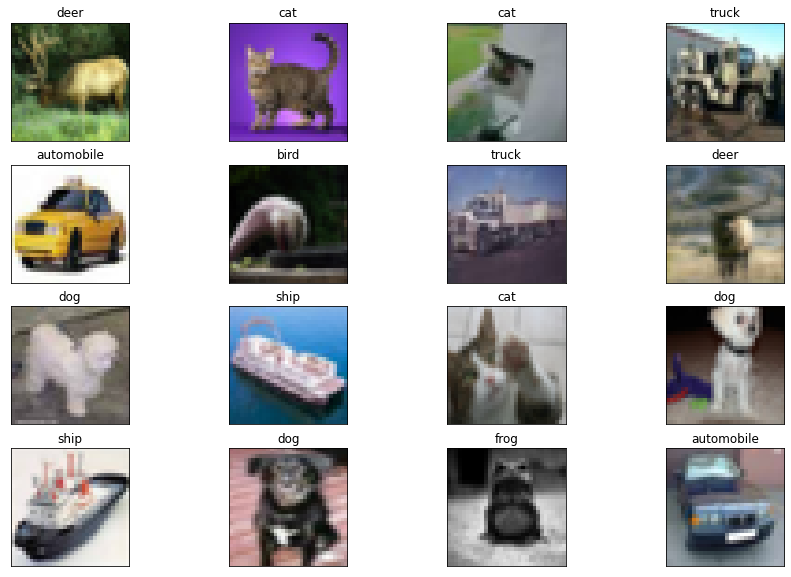

In [7]:
import matplotlib.pyplot as plt

#行数
height = 4

#展示图像
def imshow(img):
    img = img / 2 + 0.5  #将img范围变换到[0,1]
    plt.imshow(np.transpose(img, (1, 2, 0))) #将numpy数组转置，使之可以转换成图像

# 获取一批样本
images, labels = iter(train_loader).next()
images = images.numpy()

# 显示图像，标题为类名
fig = plt.figure(figsize=(15, 10))
# 显示16张图片
for i in np.arange(batch_size):
    ax = fig.add_subplot(height, int(batch_size/height), i+1, xticks=[], yticks=[])
    imshow(images[i])
    #为每张图设置标题（类名）
    ax.set_title(classes[labels[i]])

## 2.搭建Alexnet网络结构

### 载入库

In [8]:
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.autograd import Variable

### 定义Alexnet网络结构
    Alexnet由5个卷积层和3个全连接层组成，深度总共8层。

    cov1：
    1.输入size为32x32x3的数据
    2.使用96个size为5x5x3的kernel，采用stride为2，padding为2的方式进行卷积，得到大小为16x16x96的卷积层
    3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内
    4.以kernel_size为2，stride为2的方式进行maxpool降采样，得到size为8x8x96的数据

    cov2：
    1.输入size为8x8x96的数据
    2.使用256个size为5x5x96的kernel，采用stride为1，padding为2的方式进行卷积，得到大小为8x8x256的卷积层
    3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内
    4.以kernel_size为2，stride为2的方式进行maxpool降采样，得到size为4x4x256的数据

    cov3：
    1.输入size为4x4x256的数据
    2.使用384个size为3x3x256的kernel，采用stride为1，padding为1的方式进行卷积，得到大小为4x4x384的卷积层
    3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内

    cov4：
    1.输入size为4x4x384的数据
    2.使用384个size为3x3x384的kernel，采用stride为1，padding为1的方式进行卷积，得到大小为4x4x384的卷积层
    3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内

    cov5：
    1.输入size为4x4x384的数据
    2.使用384个size为3x3x384的kernel，采用stride为1，padding为1的方式进行卷积，得到大小为4x4x384的卷积层
    3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内
    4.以kernel_size为2，stride为2的方式进行maxpool降采样，得到size为2x2x384的数据

    fc6:
    1.4096个神经元
    2.3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内

    fc7:
    1.4096个神经元
    2.3.使用relu作为激励函数，来确保特征图的值范围在合理范围之内

    fc8:
    10个神经元

In [9]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.Conv = nn.Sequential(
            # cov1
            # IN : 3*32*32
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=5,stride=2,padding=2),      # 论文中kernel_size = 11,stride = 4,padding = 2
            nn.ReLU(),
            # IN : 96*16*16
            nn.MaxPool2d(kernel_size=2,stride=2),              # 论文中为kernel_size = 3,stride = 2
            
            # cov2
            # IN : 96*8*8
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # IN :256*8*8
            nn.MaxPool2d(kernel_size=2,stride=2),              # 论文中为kernel_size = 3,stride = 2
            
            #cov3
            # IN : 256*4*4
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # cov4
            # IN : 384*4*4
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # cov5
            # IN : 384*4*4
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # IN : 384*4*4
            nn.MaxPool2d(kernel_size=2, stride=2),              # 论文中为kernel_size = 3,stride = 2
            # OUT : 384*2*2
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=384 * 2 * 2, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10),
        )
        self.init_w

    def init_w(self):
        # 初始化权重
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,0,0.01)
                nn.init.constant_(m.bias,0)
                
    def forward(self,x):
        # forward
        x = self.Conv(x)
        x = x.view(-1, 384 * 2 * 2)
        x = self.linear(x)
        return x

### Class AlexNet
#### __init__
    定义网络结构，并用init_w初始化权重
#### init_w
    初始化权重
#### forward
    forward计算

### 初始化网络
    通过打印网络，我们可以清晰的看到网络的结构

In [10]:
# 显示网络参数量
def Init_net(p=None):  # p为 True 则打印网络结构
    global model
    model = AlexNet()
    #查看GPU是否能够使用
    if torch.cuda.is_available():
        model = model.cuda()
    if p:
        print(model)
    
Init_net(p=True)

AlexNet(
  (Conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=1536, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=10, bias=True)
  )

## 3.编写训练神经网络的函数

### 交叉熵损失函数：CrossEntropyLoss  
    该损失函数结合了nn.LogSoftmax()和nn.NLLLoss()两个函数。它在做分类（具体几类）训练的时候是非常有用的。在训练过程中，对于每个类分配权值，可选的参数权值应该是一个1D张量。当你有一个不平衡的训练集时，这是是非常有用的。


### 选择优化器：Adam
    Adam 是一种可以替代传统随机梯度下降过程的一阶优化算法，它能基于训练数据迭代地更新神经网络权重。


### 构建训练函数

In [11]:
import time

def train_cnn(lr=0.01, iteration=None, epochs=1, weight_decay=0,
              lr_decay=None,  # 输入数组 [step_size, gamma]
              train_num=None,  #是否使用更小的数据集来进行训练
              valid=False,   #是否使用验证集数据
              show_iter=True,  #是否展示迭代过程
              criterion=nn.CrossEntropyLoss(),  # 默认损失函数为交叉熵损失函数
              save=None , # 输入存储名文件(不用包含后缀)
              p_datasize=False  # 打印数据集大小
             ):
    # 计时开始
    time_start=time.time()
    
    # 初始化网络
    Init_net()
    
    # 若需要更小的数据集，则进行如下处理
    if train_num:
        train_loader,valid_loader,test_loader=get_loader(train_num=train_num, p=p_datasize)
        a=[]
        for data,target in train_loader:
            a.append((data,target))
        train_loader = a
        a=[]
        for data,target in valid_loader:
            a.append((data,target))
        valid_loader = a
        a=[]
        for data,target in test_loader:
            a.append((data,target))
        test_loader = a
    else:
        train_loader,valid_loader,test_loader=get_loader(p=p_datasize)
        
    # 选择 Adam 算法进行优化
    optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay) 
    
    # 学习率的迭代（learning rate decay）
    if lr_decay:
        step_size, gamma = lr_decay
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=30, gamma=0.1)
    
    if iteration is None:
        iteration = epochs * len(train_loader)
    
    #plot_step -= plot_step%int(1/valid_size-1)
    valid_loss_min = np.Inf 
    train_liter = 0  # train set 已迭代次数
    valid_liter = 0  # valid set 已迭代次数
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    for epoch in range(1, epochs+1):
        
        # 每个 epoch 重置 loss
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0

        # 将模型切换为训练模式
        model.train()
        
        i = 0
        for data, target in train_loader:  # 按 batch_size 从训练集的 data_loader 中取出数据
            if train_liter>=iteration:
                break
            train_liter += 1  # 已迭代次数
            i += 1  # 此epoch内迭代次数
            
            # 如果 cuda available 的话切换为 cuda
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 重置梯度
            optimizer.zero_grad()
            # forward
            output = model(data)
            # 计算一个 batch_size 的损失函数
            loss = criterion(output, target)
            # backward: 计算 backward gradient
            loss.backward()
            # 进行迭代，更新参数
            optimizer.step()
            if lr_decay:
                scheduler.step()
            # 更新 train_loss
            train_loss += loss.item()*data.size(0)

            #计算准确率
            _, pred = output.max(1) # 以每行分数最大者为预测的类别
            num_correct = (pred == target).sum().item()  # 累计预测准确的数量
            acc = num_correct/target.shape[0]
            train_acc = train_acc + acc  # 累加每个 batch 的准确率
            #if i % plot_step==0:
            train_loss_list.append(loss.item()*data.size(0))
            train_acc_list.append(acc)
            #print('Epoch: {} \t Liter: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.4f} \tValidation Loss: {:.6f} \tValidation Acc: {:.4f}'.format(epoch, i, train_loss/i, train_acc/i, valid_loss, valid_acc))
            
        
        if valid:
            j=0
            # 切换为测试模式
            model.eval()
            for data, target in valid_loader:
                j+=1
                if valid_liter>=int(iteration*valid_size/(1-valid_size)):
                    break
                valid_liter += 1  # valid set 已迭代次数
                # 如果 cuda available 的话切换为 cuda
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                # forward
                output = model(data)
                # 计算一个 batch_size 的损失函数
                loss = criterion(output, target)
                # 更新 valid_loss 
                valid_loss += loss.item()*data.size(0)
                #计算准确率
                _, pred = output.max(1) # 以每行分数最大者为预测的类别
                num_correct = (pred == target).sum().item()  # 累计预测准确的数量
                acc = num_correct/target.shape[0]
                valid_acc += acc  # 累加每个 batch 的准确率
                #if i % int(plot_step/(1/valid_size-1))==0:
                valid_loss_list.append(loss.item()*data.size(0))
                valid_acc_list.append(acc)
                #print('Epoch: {} \t Liter: {}\tTraining Loss: {:.6f} \tTraining Acc: {:.4f} \tValidation Loss: {:.6f} \tValidation Acc: {:.4f}'.format(epoch, i, train_loss/i, train_acc/i, valid_loss/j, valid_acc/j))
                

        # 计算一个 epoch 的平均损失和平均准确率
        train_loss /= i
        train_acc /= i

        if valid:
            valid_loss /= j
            valid_acc /= j        

        # 打印训练集与验证集的损失函数 
        if show_iter:
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.4f} \tValidation Loss: {:.6f} \tValidation Acc: {:.4f}'.format(epoch, train_loss, train_acc, valid_loss, valid_acc))

        # 如果验证集损失函数减少，就保存模型。
        if valid_loss <= valid_loss_min:
            model_dict_opt = model.state_dict()
            epoch_opt = epoch
            train_lost_opt = train_loss
            train_lost_acc = train_acc
            valid_loss_opt = valid_loss
            train_lost_acc = train_acc
    
    # 计时结束
    time_end=time.time()
    print('total time: ',time.strftime("%H:%M:%S", time.gmtime(time_end-time_start)))
    
    #保存模型
    if save:
        torch.save(model_dict_opt, save+'.pt')
    
    
    #打印 Best Model
    print('THE BEST:\n', 'Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.4f} \tValidation Loss: {:.6f} \tValidation Acc: {:.4f}'.format(epoch, train_loss, train_acc, valid_loss, valid_acc))
    return {'lr':lr,'iteration':iteration,'epochs':epochs,'weight_decay':weight_decay,'lr_decay':lr_decay,'criterion':criterion,
            'train_loss':train_loss,'train_acc':train_acc,'valid_loss':valid_loss,'valid_acc':valid_acc,
           'train_loss_list':train_loss_list,'train_acc_list':train_acc_list,
           'valid_loss_list':valid_loss_list,'valid_acc_list':valid_acc_list}

### 构建画图函数

    可根据选择，画train_loss or train_acc or valid_loss or valid_acc

In [42]:
# 画图
def draw(train_loss_list=None,train_acc_list=None,
        valid_loss_list=None,valid_acc_list=None,
        title=None,mark=None,n=6):
    #若未指定打点样式则默认用‘.’
    if mark==None:
        mark=['.']
    # 创建画布
    plt.figure(figsize=(12,4))
    
    #每n个点取平均
    def trans(l,n):
        if l==None:
            return None
        l1=[]
        for i in range(len(l)):
            l1.append(sum(l[i:i+n])/n)
        return l1[:-int(len(l1)*0.05)]
    
    #构造横坐标
    
    train_loss_list = trans(train_loss_list,n)
    train_acc_list = trans(train_acc_list,n)
    valid_loss_list = trans(valid_loss_list,n)
    valid_acc_list = trans(valid_acc_list,n)
    
    x = list(range(int(n/2),len(train_loss_list)*n+int(n/2)))
    if valid_loss_list:
        p=int(len(train_loss_list)/len(valid_loss_list))
    x = x[:len(train_loss_list)]
    
    
    if valid_loss_list:
        y = np.linspace(1,x[-1],len(valid_loss_list))   
    
    if (train_loss_list and type(train_loss_list[0]) == list) or (train_acc_list and type(train_acc_list[0]) == list) or \
    (valid_loss_list and type(valid_loss_list[0]) == list) or (valid_acc_list and type(valid_acc_list[0]) == list):   
        pass
    else:
        
        #loss
        plt.subplot(121)
        if train_loss_list:
            s1=plt.scatter(x,train_loss_list, marker=mark[0],c='blue')
        if valid_loss_list:
            s2=plt.scatter(y,valid_loss_list, marker=mark[0],c='red')
        #添加图例
        if train_loss_list and valid_loss_list:
            plt.legend((s1,s2),('train','valid'),loc='best')
        elif train_loss_list:
            plt.legend('train',loc='best')
        elif valid_loss_list:
            plt.legend('valid',loc='best')
        plt.xlabel('iteration')
        plt.ylabel('train loss')
        if title:
            plt.title(title)
            
        #accuracy
        plt.subplot(122)
        if train_acc_list:
            s1=plt.scatter(x,train_acc_list, marker=mark[-1],c='blue')
        if valid_acc_list:
            s2=plt.scatter(y,valid_acc_list, marker=mark[-1],c='red')
        #添加图例
        if train_acc_list and valid_acc_list:
            plt.legend((s1,s2),('train','valid'),loc='best')
        elif train_acc_list:
            plt.legend('train',loc='best')
        elif valid_acc_list:
            plt.legend('valid',loc='best')
        plt.xlabel('iteration')
        plt.ylabel('train accuracy')
        
        #添加标题
        if title:
            plt.title(title)

## 4.优化超参数

### Step1: 过拟合一个小样本 (10 batches)
    选择几个learning rate,过拟合一个包含10个batches的小样本

#### learning rate = 1e-3
    先选择一个learning rate

In [44]:
# 从数据集中抽取 10 个 batch
train_num = 10 * batch_size
# 设置学习率为 1e-3
lr = 1e-3
dic1 = train_cnn(epochs=70, lr=lr, train_num=160, valid=False, show_iter=False, p_datasize=True)

训练集大小： 128
验证集大小： 32
测试集大小： 10000
total time:  00:01:15
THE BEST:
 Epoch: 70 	Training Loss: 0.000007 	Training Acc: 1.0000 	Validation Loss: 0.000000 	Validation Acc: 0.0000


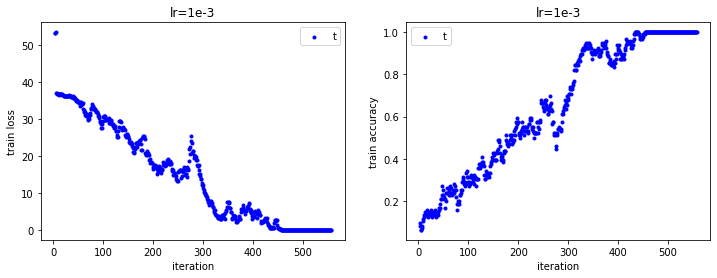

In [45]:
draw(train_loss_list=dic1['train_loss_list'],train_acc_list=dic1['train_acc_list'],
        title='lr=1e-3')

观察图像可以发现，train_loss下降遇到瓶颈，推断是learning rate过高，所以降低learning rate！

#### learning rate = 1e-4

In [46]:
# 从数据集中抽取 10 个 batch
train_num = 10 * batch_size
# 设置学习率为 1e-4
lr = 1e-4
dic2 = train_cnn(epochs=70, lr=lr, train_num=160, valid=False, show_iter=False, p_datasize=True)

训练集大小： 128
验证集大小： 32
测试集大小： 10000
total time:  00:01:15
THE BEST:
 Epoch: 70 	Training Loss: 0.010557 	Training Acc: 1.0000 	Validation Loss: 0.000000 	Validation Acc: 0.0000


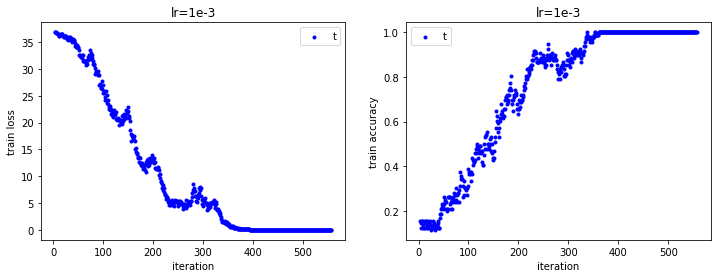

In [47]:
draw(train_loss_list=dic2['train_loss_list'],train_acc_list=dic2['train_acc_list'],
        title='lr=1e-3')

### Step2: 在一个区间内寻找一个合适的学习率
    在1e-2, 1e-3, 1e-4, 1e-5中选择合适的学习率使得模型能在 iteration < 150 就有明显下降
    在训练的过程中，加上一个较小的正则，即 weight_decay

In [48]:
import warnings
warnings.filterwarnings("ignore")

print('iteration=150')
# 设置学习率区间
lr_list = [1e-2, 1e-3, 1e-4, 1e-5]
# 设置一个较小的正则
weight_decay = 1e-5
dic3=[0,0,0,0]
i=0
for lr in lr_list:
    print('\n'+'*'*30)
    print('\nlr=','%e'%lr)
    dic3[i]=train_cnn(iteration=150, lr=lr, valid=True, show_iter=False, weight_decay=weight_decay)
    i+=1    

iteration=150

******************************

lr= 1.000000e-02
total time:  00:00:26
THE BEST:
 Epoch: 1 	Training Loss: 10591.597319 	Training Acc: 0.0842 	Validation Loss: 35.906224 	Validation Acc: 0.1053

******************************

lr= 1.000000e-03
total time:  00:00:28
THE BEST:
 Epoch: 1 	Training Loss: 42.507046 	Training Acc: 0.1079 	Validation Loss: 35.927210 	Validation Acc: 0.0888

******************************

lr= 1.000000e-04
total time:  00:00:30
THE BEST:
 Epoch: 1 	Training Loss: 34.417396 	Training Acc: 0.1575 	Validation Loss: 31.991210 	Validation Acc: 0.1941

******************************

lr= 1.000000e-05
total time:  00:00:31
THE BEST:
 Epoch: 1 	Training Loss: 36.494162 	Training Acc: 0.1267 	Validation Loss: 34.197686 	Validation Acc: 0.1661


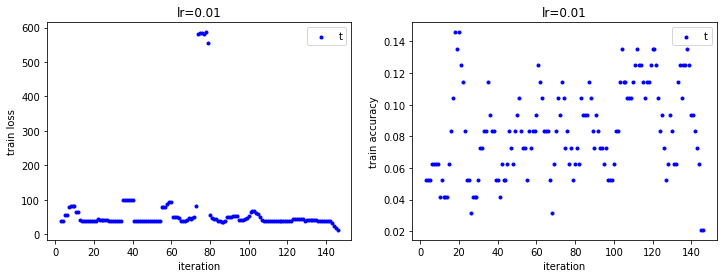

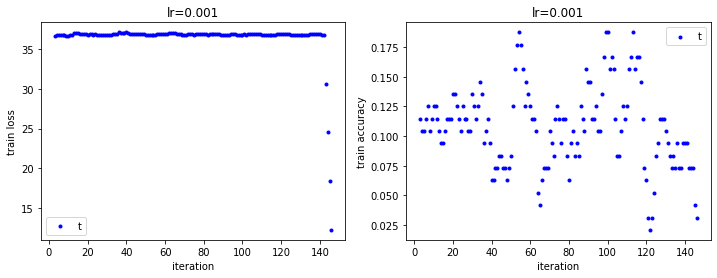

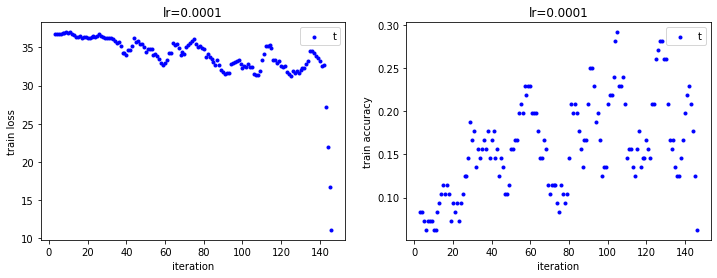

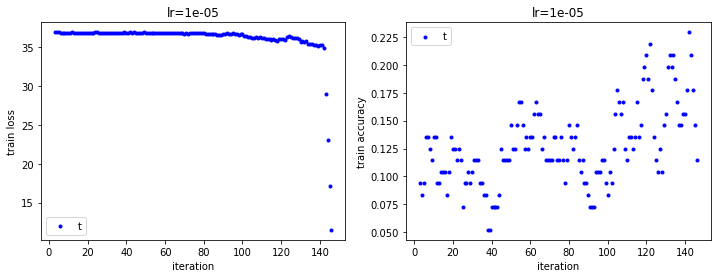

In [66]:
i=0
for lr in lr_list:
    draw(train_loss_list=dic3[i]['train_loss_list'][5:],train_acc_list=dic3[i]['train_acc_list'][5:],
        title='lr='+str(lr),n=6)
    i+=1

#### 关于为什么有时验证集的表现优于训练集：
    训练的过程在验证的过程之前，而且training loss和training acc是取1个epoch内的结果，所以在前几个epoch中验证集的表现优于训练集也是很正常的。

#### 通过图像我们可以发现

    lr=1e-1 时loss较大（注意图像左上角的单位）。
    lr=1e-2 时loss下降困难。
    lr=1e-3 时loss下降曲线较为理想。
    lr=1e-4 时loss过了很久才开始下降。

### Step3: Coarse	grid
    选择上一步得到的一个较好的learning rate，在其附近取几个值。
    同时也取几个正则值。
    这样两类超参数组建成一个网络，通过循环，每组超参数训练3个epoch，选择其中最佳的一组超参数。
    
    Epochs = 3
    weight_decay : 1e-3, 1e-4, 1e-5
    lr : 0.6e-4, 0.8e-4, 1e-4, 1.2e-4


******************************

lr= 6.000000e-05
weight_decay= 1.000000e-03
total time:  00:14:34
THE BEST:
 Epoch: 3 	Training Loss: 18.085862 	Training Acc: 0.5898 	Validation Loss: 17.591317 	Validation Acc: 0.6033

******************************

lr= 6.000000e-05
weight_decay= 1.000000e-04
total time:  00:14:36
THE BEST:
 Epoch: 3 	Training Loss: 16.703515 	Training Acc: 0.6218 	Validation Loss: 19.364298 	Validation Acc: 0.5807

******************************

lr= 6.000000e-05
weight_decay= 1.000000e-05
total time:  00:15:53
THE BEST:
 Epoch: 3 	Training Loss: 16.609781 	Training Acc: 0.6241 	Validation Loss: 16.993982 	Validation Acc: 0.6165

******************************

lr= 8.000000e-05
weight_decay= 1.000000e-03
total time:  00:15:08
THE BEST:
 Epoch: 3 	Training Loss: 17.942242 	Training Acc: 0.5905 	Validation Loss: 16.777828 	Validation Acc: 0.6125

******************************

lr= 8.000000e-05
weight_decay= 1.000000e-04
total time:  00:14:29
THE BEST:
 Epoch: 3 	Trai

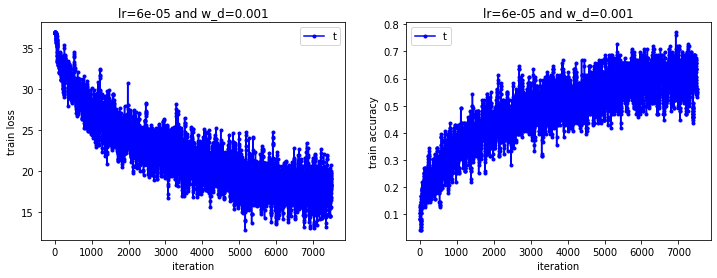

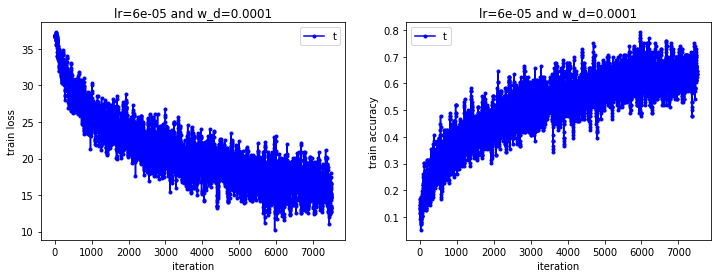

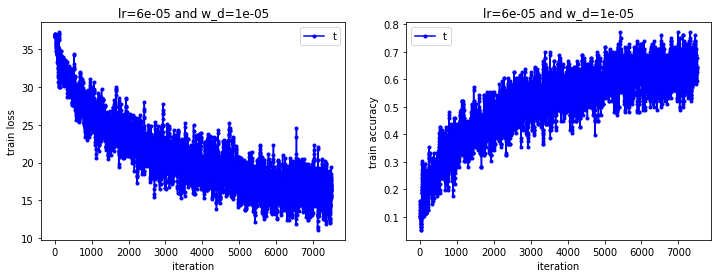

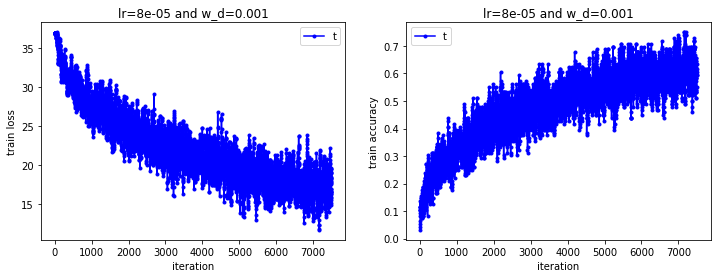

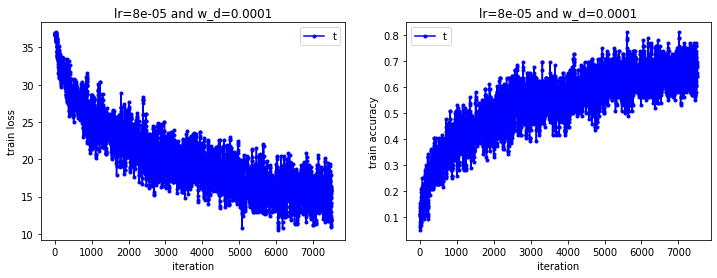

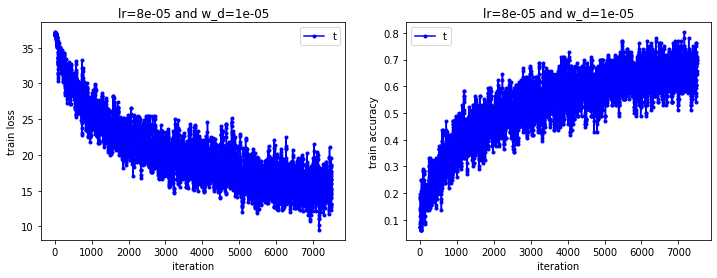

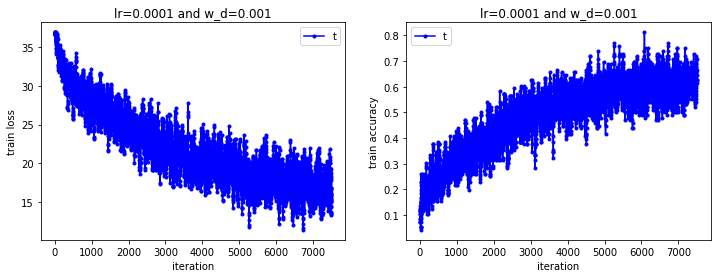

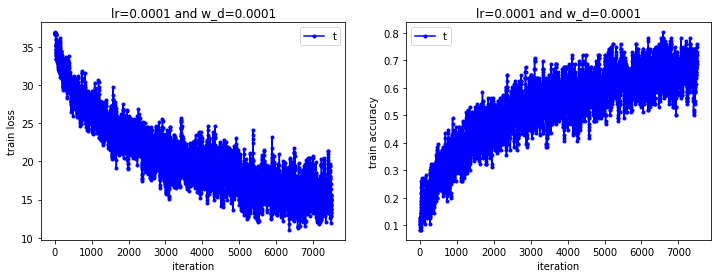

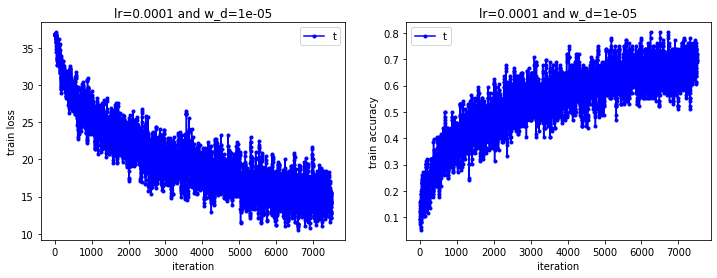

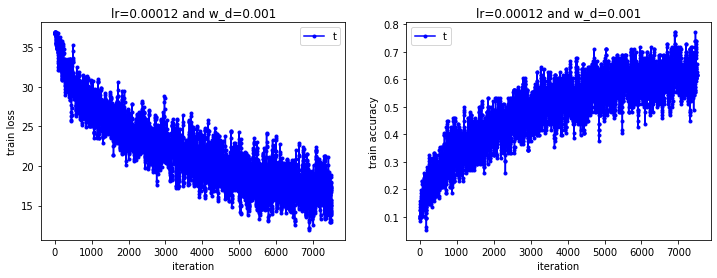

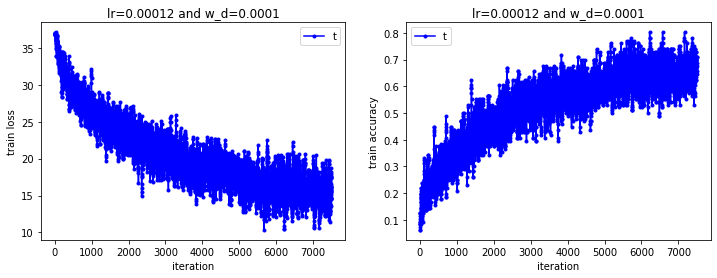

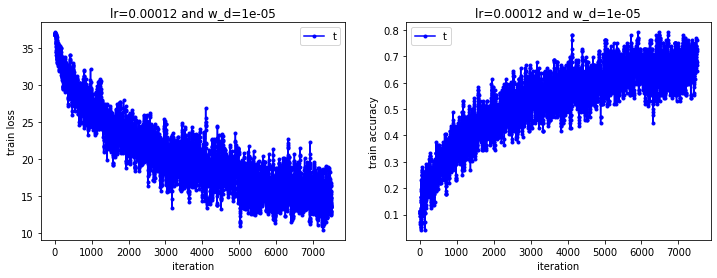

In [16]:
#设置epochs
epochs = 3
# 设置学习率区间
lr_list = [0.6e-4, 0.8e-4, 1e-4, 1.2e-4]
# 设置正则区间
weight_decay_list = [1e-3, 1e-4, 1e-5]
for lr in lr_list:
    for weight_decay in weight_decay_list:
        print('\n'+'*'*30)
        print('\nlr=','%e'%lr)
        print('weight_decay=','%e'%weight_decay)
        dic=train_cnn(epochs=epochs, lr=lr, valid=True, weight_decay=weight_decay, show_iter=False)
        draw(train_loss_list=dic['train_loss_list'],train_acc_list=dic['train_acc_list'],
             title='lr='+str(lr)+' and w_d='+str(weight_decay))

### Step4: 用上一步得到的最好的learning rate和weight_decay在整个数据集上训练10个epoch
    选择上一步中得到的网络中最好的一组超参数，即：
    lr=8e-5
    weight_decay=1e-5
    
    在整个数据集上训练10个epoch，存储为 model1.pt

In [50]:
#设置epochs
epochs = 10
#设置learning rate
lr=0.8e-4
#设置weight_decay
weight_decay=1e-5
#将此次训练得到的模型命名为 model1 ,并保存
name='model1'

#打印出learning rate和weight_decay
print('lr=',lr)
print('weight_decay=',weight_decay)

#在整个数据集上训练卷积神经网络
dic5=train_cnn(epochs=epochs, lr=lr, valid=True, weight_decay=weight_decay, show_iter=True,save=name)

lr= 8e-05
weight_decay= 1e-05
Epoch: 1 	Training Loss: 25.845226 	Training Acc: 0.3825 	Validation Loss: 21.684576 	Validation Acc: 0.4972
Epoch: 2 	Training Loss: 19.310425 	Training Acc: 0.5609 	Validation Loss: 17.759663 	Validation Acc: 0.5977
Epoch: 3 	Training Loss: 16.087443 	Training Acc: 0.6386 	Validation Loss: 15.999081 	Validation Acc: 0.6467
Epoch: 4 	Training Loss: 13.434112 	Training Acc: 0.7035 	Validation Loss: 14.960355 	Validation Acc: 0.6789
Epoch: 5 	Training Loss: 11.036171 	Training Acc: 0.7545 	Validation Loss: 14.739747 	Validation Acc: 0.6896
Epoch: 6 	Training Loss: 8.765285 	Training Acc: 0.8037 	Validation Loss: 15.064607 	Validation Acc: 0.6899
Epoch: 7 	Training Loss: 6.582672 	Training Acc: 0.8549 	Validation Loss: 15.435976 	Validation Acc: 0.7126
Epoch: 8 	Training Loss: 4.870605 	Training Acc: 0.8927 	Validation Loss: 16.825188 	Validation Acc: 0.7085
Epoch: 9 	Training Loss: 3.620464 	Training Acc: 0.9207 	Validation Loss: 18.362135 	Validation Acc: 

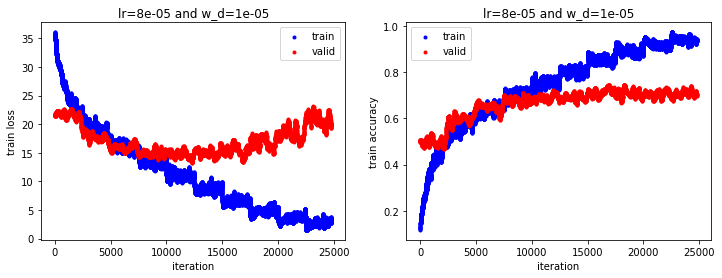

In [51]:
#画图
draw(train_loss_list=dic5['train_loss_list'],train_acc_list=dic5['train_acc_list'],
     valid_loss_list=dic5['valid_loss_list'],valid_acc_list=dic5['valid_acc_list'],
     title='lr='+str(lr)+' and w_d='+str(weight_decay), n=60)

#### 关于为什么在前几个epoch中验证集的表现优于训练集：
    训练的过程在验证的过程之前，而且training loss和training acc是取1个epoch内的结果，所以在前几个epoch中验证集的表现优于训练集也是很正常的。
    
#### 由于train_loss一直在降低，并没有遇到瓶颈，所以不设置learning rate decay

#### 上面结果最后几个epoch中训练集准确率提高，而验证集准确率降低，过拟合！增大weight_decay！
    lr=8e-5
    weight_decay=1e-4
    
    在整个数据集上训练10个epoch,存储为 model2.pt

In [52]:
#设置epochs
epochs = 15
#设置learning rate
lr=0.8e-4
#设置weight_decay
weight_decay=1e-4
#将此次训练得到的模型命名为 model1 ,并保存
name='model2'

#打印出learning rate和weight_decay
print('lr=',lr)
print('weight_decay=',weight_decay)

#在整个数据集上训练卷积神经网络
dic6=train_cnn(epochs=epochs, lr=lr, valid=True, weight_decay=weight_decay, show_iter=True,save=name)

lr= 8e-05
weight_decay= 0.0001
Epoch: 1 	Training Loss: 26.152110 	Training Acc: 0.3747 	Validation Loss: 21.611099 	Validation Acc: 0.5001
Epoch: 2 	Training Loss: 19.714604 	Training Acc: 0.5516 	Validation Loss: 18.671331 	Validation Acc: 0.5756
Epoch: 3 	Training Loss: 16.363081 	Training Acc: 0.6339 	Validation Loss: 16.537549 	Validation Acc: 0.6225
Epoch: 4 	Training Loss: 13.703320 	Training Acc: 0.6966 	Validation Loss: 14.962472 	Validation Acc: 0.6744
Epoch: 5 	Training Loss: 11.308077 	Training Acc: 0.7518 	Validation Loss: 14.905162 	Validation Acc: 0.6801
Epoch: 6 	Training Loss: 9.147673 	Training Acc: 0.8011 	Validation Loss: 14.151662 	Validation Acc: 0.7048
Epoch: 7 	Training Loss: 7.121913 	Training Acc: 0.8454 	Validation Loss: 16.268936 	Validation Acc: 0.6851
Epoch: 8 	Training Loss: 5.409743 	Training Acc: 0.8815 	Validation Loss: 15.236205 	Validation Acc: 0.7114
Epoch: 9 	Training Loss: 4.046399 	Training Acc: 0.9104 	Validation Loss: 16.375605 	Validation Acc:

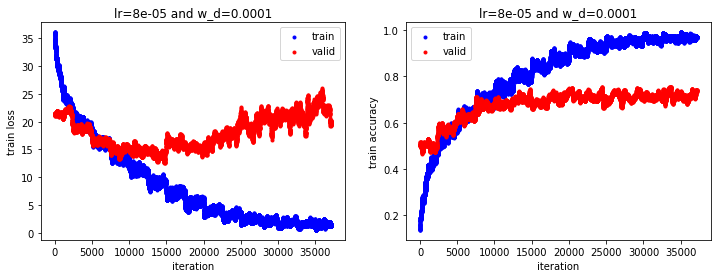

In [53]:
#画图
draw(train_loss_list=dic6['train_loss_list'],train_acc_list=dic6['train_acc_list'],
     valid_loss_list=dic6['valid_loss_list'],valid_acc_list=dic6['valid_acc_list'],
     title='lr='+str(lr)+' and w_d='+str(weight_decay), n=60)

## 5.测试

### 加载训练好的模型在测试集上测试

In [54]:
name='model2'
#加载模型
model = AlexNet()
if torch.cuda.is_available():
    model = model.cuda()
criterion=nn.CrossEntropyLoss()
model.load_state_dict(torch.load(name+'.pt'))

_,_,test_loader=get_loader(p=False)

### 测试！测试！测试！

In [55]:
test_loss = 0.0
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

model.eval()
for data, target in test_loader:
    # 如果 cuda available 的话切换为 cuda
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward
    output = model(data)
    # 计算一个 batch_size 的损失函数
    loss = criterion(output, target)
    # 更新 test_loss 
    test_loss += loss.item()*data.size(0)
    
    # 计算准确率
    _, pred = output.max(1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # 累计每个类别预测正确的数目
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# 计算平均 test_loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: no training examples' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.537338

Test Accuracy of airplane: 72% (725/1000)
Test Accuracy of automobile: 79% (798/1000)
Test Accuracy of  bird: 64% (648/1000)
Test Accuracy of   cat: 54% (548/1000)
Test Accuracy of  deer: 61% (617/1000)
Test Accuracy of   dog: 55% (556/1000)
Test Accuracy of  frog: 69% (696/1000)
Test Accuracy of horse: 77% (779/1000)
Test Accuracy of  ship: 76% (769/1000)
Test Accuracy of truck: 83% (834/1000)

Test Accuracy (Overall): 69% (6970/10000)


### 结果：综合准确率为 69%
    

### 展示测试样本结果

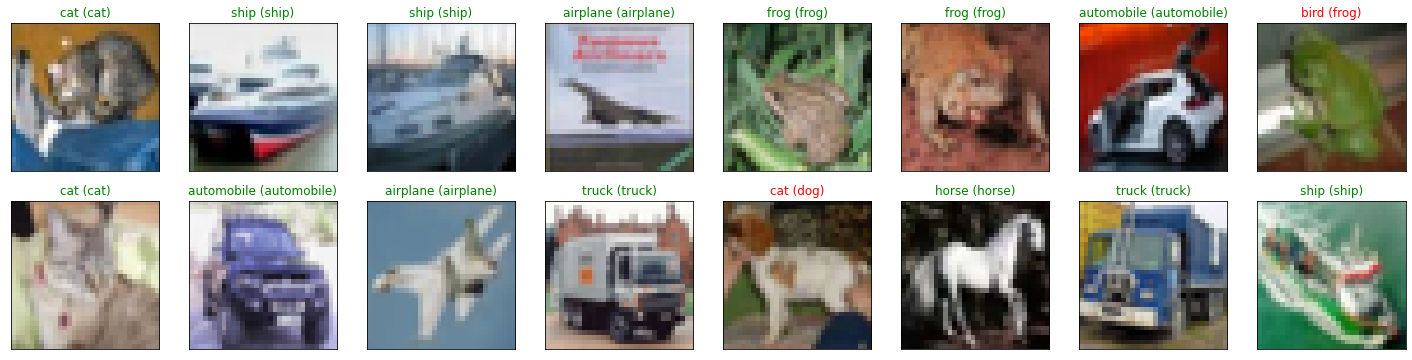

In [56]:
import warnings
warnings.filterwarnings("ignore")

# 得到一批测试数据
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# 变为cuda模式
if torch.cuda.is_available():
    images = images.cuda()

# 得到输出
output = model(images)
# 预测
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# 展示图片
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [68]:
# 保存最佳模型
torch.save(model.state_dict(), 'Best.pt')